In [1]:
import os, json, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.append("..")
from src.tasks.game24 import Game24

In [2]:
lost_logs  = \
{
    "num_agents" : [3, 10, 5, 3, 10, 5, 5, 10, 5, 10],
    "difficulty" : [0, 0, 0, 0, 0, 0, 9, 9, 9, 9],
    "model" : ["gpt-3.5-turbo-0125]\n(0 difficulty)"]*3 + ["gpt-3.5-turbo-1106]\n(0 difficulty)"]*3 +["gpt-3.5-turbo-0125]\n(9 difficulty)"]*2 +["gpt-3.5-turbo-1106]\n(9 difficulty)"]*2,
    "accuracy" : [5, 34, 18, 12, 44, 16, 2, 14, 10, 10],
    "cost" : [None]*6 + [0.55, 1.09, 0.86, 1.69]
}

df_lost = pd.DataFrame(lost_logs)
df_lost["backtrack"] = False
df_lost

,num_agents,difficulty,model,accuracy,cost,backtrack
0,3,0,gpt-3.5-turbo-0125]\n(0 difficulty),5,NaN,False
1,10,0,gpt-3.5-turbo-0125]\n(0 difficulty),34,NaN,False
2,5,0,gpt-3.5-turbo-0125]\n(0 difficulty),18,NaN,False
3,3,0,gpt-3.5-turbo-1106]\n(0 difficulty),12,NaN,False
4,10,0,gpt-3.5-turbo-1106]\n(0 difficulty),44,NaN,False
5,5,0,gpt-3.5-turbo-1106]\n(0 difficulty),16,NaN,False
6,5,9,gpt-3.5-turbo-0125]\n(9 difficulty),2,0.55,False
7,10,9,gpt-3.5-turbo-0125]\n(9 difficulty),14,1.09,False
8,5,9,gpt-3.5-turbo-1106]\n(9 difficulty),10,0.86,False
9,10,9,gpt-3.5-turbo-1106]\n(9 difficulty),10,1.69,False


In [3]:
def get_files_in_folder(folder_path):
    files = []
    for root, directories, filenames in os.walk(folder_path):
        for filename in filenames:
            files.append(os.path.join(root, filename))
    return files

def get_agents_difficulty_model(file_name):
    match = re.search(r'(\d+)agents.*_(\d+)start', file_name)

    if match:
        model = file_name.split("/")[-1].split("__")[0]
        num_agents = int(match.group(1))
        difficulty = int(int(match.group(2))/100)
        return num_agents, difficulty, model
    else:
        print("Pattern not found in file name:", file_name)

folder_path = '../logs_recent/analysis'
files_in_folder = get_files_in_folder(folder_path)
files_in_folder = [file for file in files_in_folder if file.endswith(".json")]

results = []
for file in files_in_folder:
    experiment = {}
    experiment["num_agents"], experiment["difficulty"], experiment["model"] = get_agents_difficulty_model(file)
    experiment["accuracy"] = Game24.get_accuracy(file, verbose=False)
    experiment["cost"] = Game24.get_cost(file, verbose=False)
    results.append(experiment)

df = pd.DataFrame(results)
df.sort_values(by=["difficulty", "model"], inplace=True)
df.reset_index(drop=True, inplace=True)
df["model"] = df.apply(lambda x: x["model"] + "\n(" + str(x["difficulty"])+" difficulty)", axis=1)
df["accuracy"] = df["accuracy"]*100
df["backtrack"] = True
display(df)

,num_agents,difficulty,model,accuracy,cost,backtrack
0,3,0,gpt-3.5-turbo-0125\n(0 difficulty),18.0,0.783629,True
1,10,0,gpt-3.5-turbo-0125\n(0 difficulty),64.0,2.001924,True
2,5,0,gpt-3.5-turbo-0125\n(0 difficulty),40.0,1.174844,True
3,3,0,gpt-3.5-turbo-1106\n(0 difficulty),26.0,1.195207,True
4,10,0,gpt-3.5-turbo-1106\n(0 difficulty),60.0,3.092521,True
5,5,0,gpt-3.5-turbo-1106\n(0 difficulty),30.0,1.905724,True
6,5,9,gpt-3.5-turbo-0125\n(9 difficulty),14.0,1.402239,True
7,10,9,gpt-3.5-turbo-0125\n(9 difficulty),28.0,2.571378,True


In [9]:
df_lost[df_lost.num_agents==10]

,num_agents,difficulty,model,accuracy,cost,backtrack
1,10,0,gpt-3.5-turbo-0125]\n(0 difficulty),34,NaN,False
4,10,0,gpt-3.5-turbo-1106]\n(0 difficulty),44,NaN,False
7,10,9,gpt-3.5-turbo-0125]\n(9 difficulty),14,1.09,False
9,10,9,gpt-3.5-turbo-1106]\n(9 difficulty),10,1.69,False


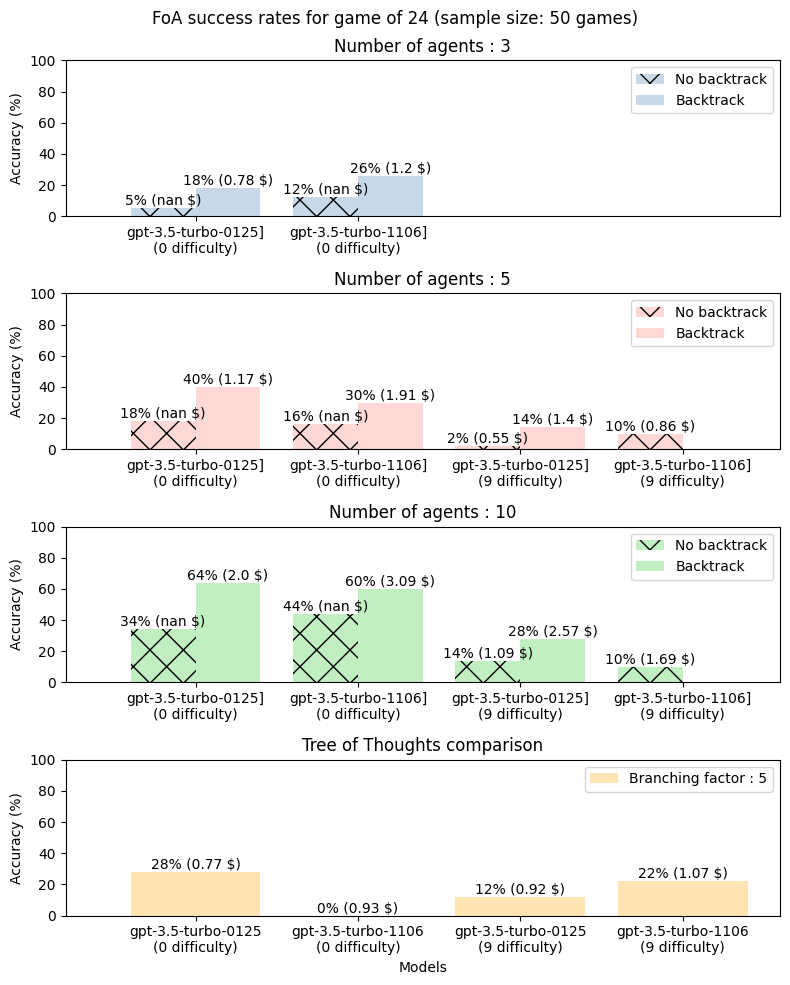

In [25]:
n_agents = [3, 5, 10]
fig, axes = plt.subplots(len(n_agents)+1, 1, figsize=(8,10))  # 2 rows, 1 column
colors = ["steelblue", "salmon", "limegreen"]
width = 0.4

for j, n in enumerate(n_agents):
    
    #####
    temp = df_lost[df_lost.num_agents == n]
    accuracies = temp.accuracy.tolist()
    models = temp.model.tolist()
    x_ticks= np.arange(len(models))
    costs = temp.cost.tolist()
    agents  = temp.num_agents.tolist()

    # Plotting accuracies
    color = colors[j]
    #axes[j].set_xlabel('Models')
    axes[j].set_ylabel('Accuracy (%)')
    bars = axes[j].bar(x=x_ticks-width/2, height=accuracies, color=color, alpha=0.3, label=f"No backtrack", width=width, hatch="x")
    axes[j].set_xticks(x_ticks, models)
    axes[j].tick_params(axis='y')
    axes[j].set_ylim(0, 100)
    axes[j].legend()

    for bar, acc, cost in zip(bars, accuracies, costs):
        axes[j].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{acc:.0f}% ({"N/A" if not cost else round(cost,2)} $)', 
                     ha='center', va='bottom', color='black')
        
    ####
    temp = df[df.num_agents == n]
    accuracies = temp.accuracy.tolist()
    models = temp.model.tolist()
    x_ticks= np.arange(len(models))
    costs = temp.cost.tolist()
    agents  = temp.num_agents.tolist()

    # Plotting accuracies
    color = colors[j]
    #axes[j].set_xlabel('Models')
    axes[j].set_ylabel('Accuracy (%)')
    bars = axes[j].bar(x=x_ticks+width/2, height=accuracies, color=color, alpha=0.3, label=f"Backtrack", width=width)
    #axes[j].set_xticks(x_ticks, models)
    axes[j].tick_params(axis='y')
    axes[j].set_ylim(0, 100)
    axes[j].set_xlim(-2*width, 9*width)
    axes[j].legend()
    axes[j].set_title(f"Number of agents : {n}")

    for bar, acc, cost in zip(bars, accuracies, costs):
        axes[j].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{acc:.0f}% ({"N/A" if not cost else round(cost,2)} $)', 
                     ha='center', va='bottom', color='black')

axes[3].set_title("Tree of Thoughts comparison")
axes[3].set_xlabel('Models')
axes[3].set_ylabel('Accuracy (%)')
tot_models = ["gpt-3.5-turbo-0125\n(0 difficulty)", "gpt-3.5-turbo-1106\n(0 difficulty)", "gpt-3.5-turbo-0125\n(9 difficulty)", "gpt-3.5-turbo-1106\n(9 difficulty)"]
tot_accuracies = [28, 0, 12, 22]
tot_costs = [0.77, 0.93, 0.92, 1.07]
bars = axes[3].bar(tot_models, tot_accuracies, color="orange", alpha=0.3, label=f"Branching factor : {5}", width=2*width)
axes[3].tick_params(axis='y')
axes[3].set_ylim(0, 100)
axes[3].set_xlim(-2*width, 9*width)
axes[3].legend()

for bar, acc, cost in zip(bars, tot_accuracies, tot_costs):
        axes[3].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{acc:.0f}% ({"N/A" if not cost else round(cost,2)} $)', 
                     ha='center', va='bottom', color='black')


plt.suptitle("FoA success rates for game of 24 (sample size: 50 games)")
plt.tight_layout()
plt.savefig("../pics/all_accuracies.png", dpi=300)
plt.show()

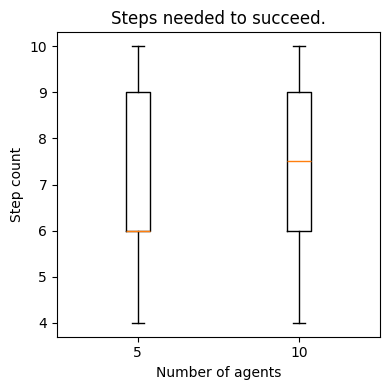

In [26]:
lengths = {}
for num_agents in [5, 10]:
    with open(f'../logs_recent/analysis/gpt-3.5-turbo-0125__{num_agents}agents_Ffoa_3evaluations_900start_950end.json') as f:
        logs = json.load(f)

    successful = []
    unsuccessful = []
    for idx in logs.keys():
        experiment = logs[idx]
        success = {"r":1} in experiment["results"]
        if success:
            successful.append(experiment)
        else:
            unsuccessful.append(experiment)

    def count_steps(experiment):
        return len([key for key in experiment.keys() if key.startswith("step_")])

    lengths_successful = []
    lengths_unsuccessful = []

    for experiment in successful:
        lengths_successful.append(count_steps(experiment))
    
    lengths[num_agents] = lengths_successful

data = [lengths[key] for key in lengths.keys()]
labels = [str(key) for key in lengths.keys()]

fig = plt.figure(figsize=(4,4))
plt.boxplot(data, labels=labels)
plt.xlabel("Number of agents")
plt.ylabel("Step count")
plt.title("Steps needed to succeed.")
plt.tight_layout()
plt.savefig("../pics/steps_to_success.png", dpi=300)
plt.show()